
### Copyright and License

© 2026, Isabel Bejerano Blazquez

This Jupyter Notebook is licensed under the **MIT License**. You are free to:

- Use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies
  of this notebook, subject to the conditions below.

**Conditions:**

- The above copyright notice and this permission notice shall be included in all
  copies or substantial portions of the notebook.

**Disclaimer:**

- The notebook is provided "as is", without warranty of any kind. The author is
  not liable for any claims or damages arising from the use of this notebook.

**Dataset Note:**

- The analyses are based on the SPARCS Hospital Inpatient Discharges dataset 
(NYC, Richmond County, 2023), licensed under the **Open Database License (ODbL)**



# Academic Healthcare Data Analysis and Predictive Pipeline

**Dataset:** [SPARCS Hospital Inpatient Discharges – New York City (Richmond County, 2023)](https://healthdata.gov/dataset/Hospital-Inpatient-Discharges-SPARCS-De-Identified/tpup-hey9/data_preview)

Locally stored under ../datasets

License: Open Database License (ODbL)


## Abstract

Administrative healthcare datasets are increasingly used in health services 
research to study utilization patterns, cost structures, and outcome proxies in 
the absence of detailed clinical variables.

This notebook presents a comprehensive, reproducible, and academically grounded
data analysis pipeline applied to the SPARCS inpatient discharge dataset for Richmond County (NYC, 2023).

This notebook presents a reproducible predictive modeling pipeline applied
to administrative inpatient discharge data from the SPARCS database. The analysis emphasizes data quality assessment, feature engineering, and supervised learning models to predict hospital length of stay (LOS).
Model performance is evaluated using out-of-sample metrics, and model
interpretability is discussed in the context of healthcare operations.

Results are interpreted under an associational framework, acknowledging the
observational and administrative nature of the data.


### Dataset Relevance

The SPARCS inpatient discharge dataset provides comprehensive, population-level 
coverage of hospitalizations in New York State through mandatory reporting by 
acute care hospitals. Its standardized structure and large sample size make it 
well suited for observational health services research focused on utilization 
and system-level outcomes.

Although administrative data lack detailed clinical measures, they offer strong 
external validity for studying inpatient care patterns, costs, and operational 
metrics. The Richmond County subset reflects care delivery in a dense urban 
setting and is therefore appropriate for analyzing hospital utilization dynamics. 
The dataset is fully de-identified and licensed under the Open Database License 
(ODbL), ensuring ethical compliance and reproducibility.

### Relevance of Hospital Length of Stay (LOS)

Length of Stay (LOS) is a core outcome in inpatient healthcare research, 
reflecting both clinical complexity and hospital operational efficiency. 
Prolonged LOS is commonly associated with increased resource utilization, higher 
costs, and challenges in discharge planning.

In administrative datasets such as SPARCS, LOS is particularly valuable because 
it is consistently recorded, minimally affected by coding discretion, and 
available for all hospitalizations. As a result, LOS serves as a reliable proxy 
outcome when detailed measures of disease severity are unavailable and is widely 
used in health services and policy research.

## 1. Analytical framework and research design

This study follows a quantitative, observational, cross-sectional research design.

The analytical pipeline is structured according to best practices in:

- Exploratory Data Analysis (Tukey, 1977)
- Applied statistics and predictive analysis
- Health services and health economics research

The notebook is organized into sequential stages:

1. Data ingestion and structural inspection
2. Data quality diagnostics
3. Cleaning and transformation
4. Exploratory data analysis
5. Predictive modeling
6. Hypothesis formulation and contrast
7. Interpretation and limitations

This structure mirrors the methodological logic of a formal academic paper.


## 2. Imports and computational environment

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, roc_auc_score

### Academic justification

The analysis is conducted using open-source scientific software to ensure 
transparency
and reproducibility.

- pandas and numpy provide deterministic data manipulation. The use of pandas 
(rather than alternatives such as polars) is justified by the
moderate size of the dataset, which contains fewer than tens of millions of 
observations.
- matplotlib enables non-parametric visualization without hidden smoothing.
- scikit-learn offers standardized implementations of statistical learning 
models.
- statsmodels provides econometric-style estimation and robust variance 
estimators, aligning the pipeline with applied health economics and health 
services research.

Although the primary objective is predictive accuracy rather than causal
inference, model coefficients are examined to provide descriptive insights.
Train–test splits and out-of-sample evaluation are therefore appropriate
and explicitly employed.


## 3. Data source and ethical considerations

The SPARCS dataset is provided by the New York State Department of Health and 
contains fully de-identified administrative discharge records.

Ethical considerations:

- No direct personal identifiers are present.
- No attempt is made to re-identify individuals.

Analysis complies with principles of beneficence, non-maleficence, and justice.

The dataset is licensed under the Open Database License (ODbL). All outputs in 
this notebook constitute Produced Works under the license.


## 4. Dataset loading and verification

In [2]:
df = pd.read_csv(
    "../datasets/Hospital_Inpatient_Discharges_SPARCS_De-Identified_NYCity_Richmond_2023.csv",
    sep=';',                    # semicolon delimiter
    quotechar='"',              # double quotes around fields
    quoting=csv.QUOTE_MINIMAL,  # only quote fields that need it
    engine='python',            # more robust than C engine
    skipinitialspace=True       # ignore spaces after ;
)

# (rows, columns)
print(f"Shape: {df.shape}")
# Convert columns to a list
print(df.columns.tolist())


Shape: (52058, 33)
['Hospital Service Area', 'Hospital County', 'Operating Certificate Number', 'Permanent Facility Id', 'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity', 'Length of Stay', 'Type of Admission', 'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code', 'CCSR Diagnosis Description', 'CCSR Procedure Code', 'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description', 'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code', 'APR Severity of Illness Description', 'APR Risk of Mortality', 'APR Medical Surgical Description', 'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3', 'Birth Weight', 'Emergency Department Indicator', 'Total Charges', 'Total Costs']


In [3]:
# Show 5 first rows
df.head()


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,M,White,Not Span/Hispanic,...,Minor,Moderate,Surgical,Medicare,Medicare,NaN,NaN,Y,"93,566.39","20,583.31"
1,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,F,Other Race,Not Span/Hispanic,...,Moderate,Major,Medical,Medicare,Medicare,Medicaid,NaN,Y,"51,564.46","11,652.85"
2,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,70 or Older,103,M,White,Not Span/Hispanic,...,Moderate,Major,Medical,Medicare,Medicare,NaN,NaN,Y,"37,003.20","9,256.67"
3,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,M,Black/African American,Not Span/Hispanic,...,Moderate,Minor,Medical,Miscellaneous/Other,Private Health Insurance,NaN,NaN,Y,"47,013.41","12,210.79"
4,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,70 or Older,103,M,White,Not Span/Hispanic,...,Extreme,Extreme,Medical,Medicare,Blue Cross/Blue Shield,NaN,NaN,Y,"38,319.00","8,827.74"


### Dataset Summary and Key Observations

Initial inspection serves as a data integrity check and ensures that:

- Dataset dimensions (rows x columns)
- The observational unit corresponds to a hospital discharge.
- Variables are consistently encoded.
- No structural corruption occurred during ingestion.

The Richmond County SPARCS inpatient discharge dataset for 2023 contains 
**52,058 hospitalizations** across **33 variables**, capturing demographic, 
administrative, clinical, and financial information. The dataset includes 
patient-level characteristics such as age group, gender, race, and ethnicity, as 
well as admission details (e.g., type of admission, discharge disposition), 
clinical classification codes (CCSR diagnosis and procedure codes, APR DRG and 
severity scores), and resource utilization indicators (length of stay, total 
charges, and total costs).

Preliminary inspection reveals:

- **Demographics:** The majority of patients fall within the 50–69 age range, 
with representation across gender and racial categories typical of the urban 
Richmond County population.  
- **Clinical Complexity:** APR severity of illness and risk of mortality codes 
indicate a spectrum from minor to extreme clinical complexity, suitable for 
associational analyses with outcomes such as length of stay (LOS) and cost.  
- **Financial Measures:** Total charges and costs exhibit right-skewed 
distributions, consistent with heavy-tailed hospital expenditure patterns. 
Log-transformations and robust preprocessing are therefore appropriate for 
predictive modeling.  
- **Administrative Consistency:** All hospital identifiers, payment typologies, 
and procedure/diagnosis codes are systematically encoded, allowing reproducible 
cross-sectional analysis and alignment with prior health services research.

Overall, the dataset is sufficiently detailed to examine associations between 
patient characteristics, clinical complexity, resource utilization, and hospital 
financial outcomes. Its size, scope, and structure make it well-suited for 
exploratory and predictive analyses, including multivariate regression of LOS 
and total charges while maintaining methodological rigor.


## 5. Structural and metadata inspection

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52058 entries, 0 to 52057
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Hospital Service Area                52058 non-null  object
 1   Hospital County                      52058 non-null  object
 2   Operating Certificate Number         52058 non-null  int64 
 3   Permanent Facility Id                52058 non-null  int64 
 4   Facility Name                        52058 non-null  object
 5   Age Group                            52058 non-null  object
 6   Zip Code - 3 digits                  51581 non-null  object
 7   Gender                               52058 non-null  object
 8   Race                                 52058 non-null  object
 9   Ethnicity                            52058 non-null  object
 10  Length of Stay                       52058 non-null  object
 11  Type of Admission                    5205

In [5]:
# Descriptive summary of all columns in a DataFrame, transposed for readability
df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hospital Service Area,52058,1,New York City,52058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hospital County,52058,1,Richmond,52058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Operating Certificate Number,52058.0,NaN,NaN,NaN,7004004.830478,3.076179,7004003.0,7004003.0,7004003.0,7004010.0,7004010.0
Permanent Facility Id,52058.0,NaN,NaN,NaN,1739.053037,1.192134,1737.0,1738.0,1740.0,1740.0,1740.0
Facility Name,52058,3,Staten Island University Hosp-North,31088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age Group,52058,5,70 or Older,16961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zip Code - 3 digits,51581,22,103,45210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,52058,2,F,28795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,52058,3,White,32115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ethnicity,52058,3,Not Span/Hispanic,41846,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import numpy as np
import pandas as pd

# Numeric summary (column-wise)
print("Numeric summary")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

numeric_summary = pd.DataFrame({
    "count": df[numeric_cols].count(),
    "missing": df[numeric_cols].isna().sum(),
    "missing_%": (df[numeric_cols].isna().mean() * 100).round(2),
    "mean": df[numeric_cols].mean(),
    "std": df[numeric_cols].std(),
    "min": df[numeric_cols].min(),
    "max": df[numeric_cols].max(),
    "unique": df[numeric_cols].nunique()
}).sort_values("missing_%", ascending=False)

print(numeric_summary)

Numeric summary
                              count  missing  missing_%          mean  \
Operating Certificate Number  52058        0        0.0  7.004005e+06   
Permanent Facility Id         52058        0        0.0  1.739053e+03   
Discharge Year                52058        0        0.0  2.023000e+03   
APR DRG Code                  52058        0        0.0  4.056524e+02   
APR MDC Code                  52058        0        0.0  1.003623e+01   
APR Severity of Illness Code  52058        0        0.0  2.015483e+00   

                                       std      min      max  unique  
Operating Certificate Number  3.076179e+00  7004003  7004010       2  
Permanent Facility Id         1.192134e+00     1737     1740       3  
Discharge Year                2.273759e-13     2023     2023       1  
APR DRG Code                  2.403629e+02        4      956     314  
APR MDC Code                  5.874633e+00        0       25      26  
APR Severity of Illness Code  9.585962e-01    

In [7]:
# Ccategorical summary (column-wise)
print("\nCategorical summary")

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

cat_summary = pd.DataFrame({
    "count": df[categorical_cols].count(),
    "missing": df[categorical_cols].isna().sum(),
    "missing_%": (df[categorical_cols].isna().mean() * 100).round(2),
    "unique": df[categorical_cols].nunique(),
    "top_value": df[categorical_cols].mode().iloc[0],
    "top_freq": df[categorical_cols].apply(lambda x: x.value_counts().iloc[0])
}).sort_values("missing_%", ascending=False)

print(cat_summary)


Categorical summary
                                     count  missing  missing_%  unique  \
Birth Weight                          5373    46685      89.68      48   
Payment Typology 3                   22211    29847      57.33       8   
Payment Typology 2                   30218    21840      41.95       8   
CCSR Procedure Description           34423    17635      33.88     281   
CCSR Procedure Code                  34423    17635      33.88     281   
Zip Code - 3 digits                  51581      477       0.92      22   
APR Severity of Illness Description  52042       16       0.03       4   
APR Risk of Mortality                52042       16       0.03       4   
Facility Name                        52058        0       0.00       3   
Hospital County                      52058        0       0.00       1   
Hospital Service Area                52058        0       0.00       1   
Patient Disposition                  52058        0       0.00      16   
Type of Admission

In [8]:
# LOW-VARIANCE COLUMNS
print("\nLow-variance columns (<1% unique non-null)")

low_variance_report = []

for col in df.columns:
    non_null = df[col].notna().sum()
    if non_null == 0:
        continue
    unique_ratio = df[col].nunique() / non_null
    if unique_ratio < 0.01:
        low_variance_report.append({
            "column": col,
            "dtype": df[col].dtype,
            "unique_values": df[col].nunique(),
            "non_null": non_null,
            "unique_ratio_%": round(unique_ratio * 100, 3)
        })

low_var_df = pd.DataFrame(low_variance_report)

if not low_var_df.empty:
    print(low_var_df.sort_values("unique_ratio_%"))
else:
    print("No low-variance columns detected.")



Low-variance columns (<1% unique non-null)
                                 column   dtype  unique_values  non_null  \
0                 Hospital Service Area  object              1     52058   
1                       Hospital County  object              1     52058   
13                       Discharge Year   int64              1     52058   
2          Operating Certificate Number   int64              2     52058   
7                                Gender  object              2     52058   
30       Emergency Department Indicator  object              2     52058   
8                                  Race  object              3     52058   
3                 Permanent Facility Id   int64              3     52058   
9                             Ethnicity  object              3     52058   
4                         Facility Name  object              3     52058   
25     APR Medical Surgical Description  object              3     52058   
23  APR Severity of Illness Description  obj

### Dataset Overview, Structural Inspection, and Variable Justification

Structural inspection allows identification of:

- **Measurement scales:** distinguishing **categorical** variables (e.g., 
gender, race, ethnicity, type of admission), **ordinal** variables (e.g., APR 
severity of illness, APR risk of mortality), and **numerical/continuous** 
variables (e.g., length of stay, total charges, total costs) to guide 
appropriate statistical modeling and ensure correct treatment of variable types 
in both descriptive and predictive analyses.  
- **Candidate dependent and independent variables:** selecting LOS, total 
charges, and discharge disposition as primary outcomes (dependant varibale), and 
patient demographics, admission characteristics, and clinical severity proxies 
as predictors (independant variables).  
- **Variables unsuitable for modeling:** identifying columns with high 
missingness, low variability, or ambiguity (e.g., certain payment typologies, 
optional procedure codes), which may bias analyses if included without careful 
treatment.

From an operational perspective, this step corresponds to **variable**
**operationalization** in empirical research, ensuring that each variable’s 
scale, completeness, and informational content support reproducible and 
theoretically grounded analyses. The observed data patterns confirm that the 
dataset is well-suited for exploring associations between patient 
characteristics, clinical complexity, resource utilization, and hospital 
financial outcomes. 

Overall, the dataset provides a strong foundation for exploratory and 
predictive analyses in health services research.


## 6. Data quality assessment

In [9]:
# Compute the proportion of missing values (NaN) per column
na_summary = df.isna().mean().sort_values(ascending=False)
na_summary[na_summary > 0]


Birth Weight                           0.896788
Payment Typology 3                     0.573341
Payment Typology 2                     0.419532
CCSR Procedure Description             0.338757
CCSR Procedure Code                    0.338757
Zip Code - 3 digits                    0.009163
APR Risk of Mortality                  0.000307
APR Severity of Illness Description    0.000307
dtype: float64

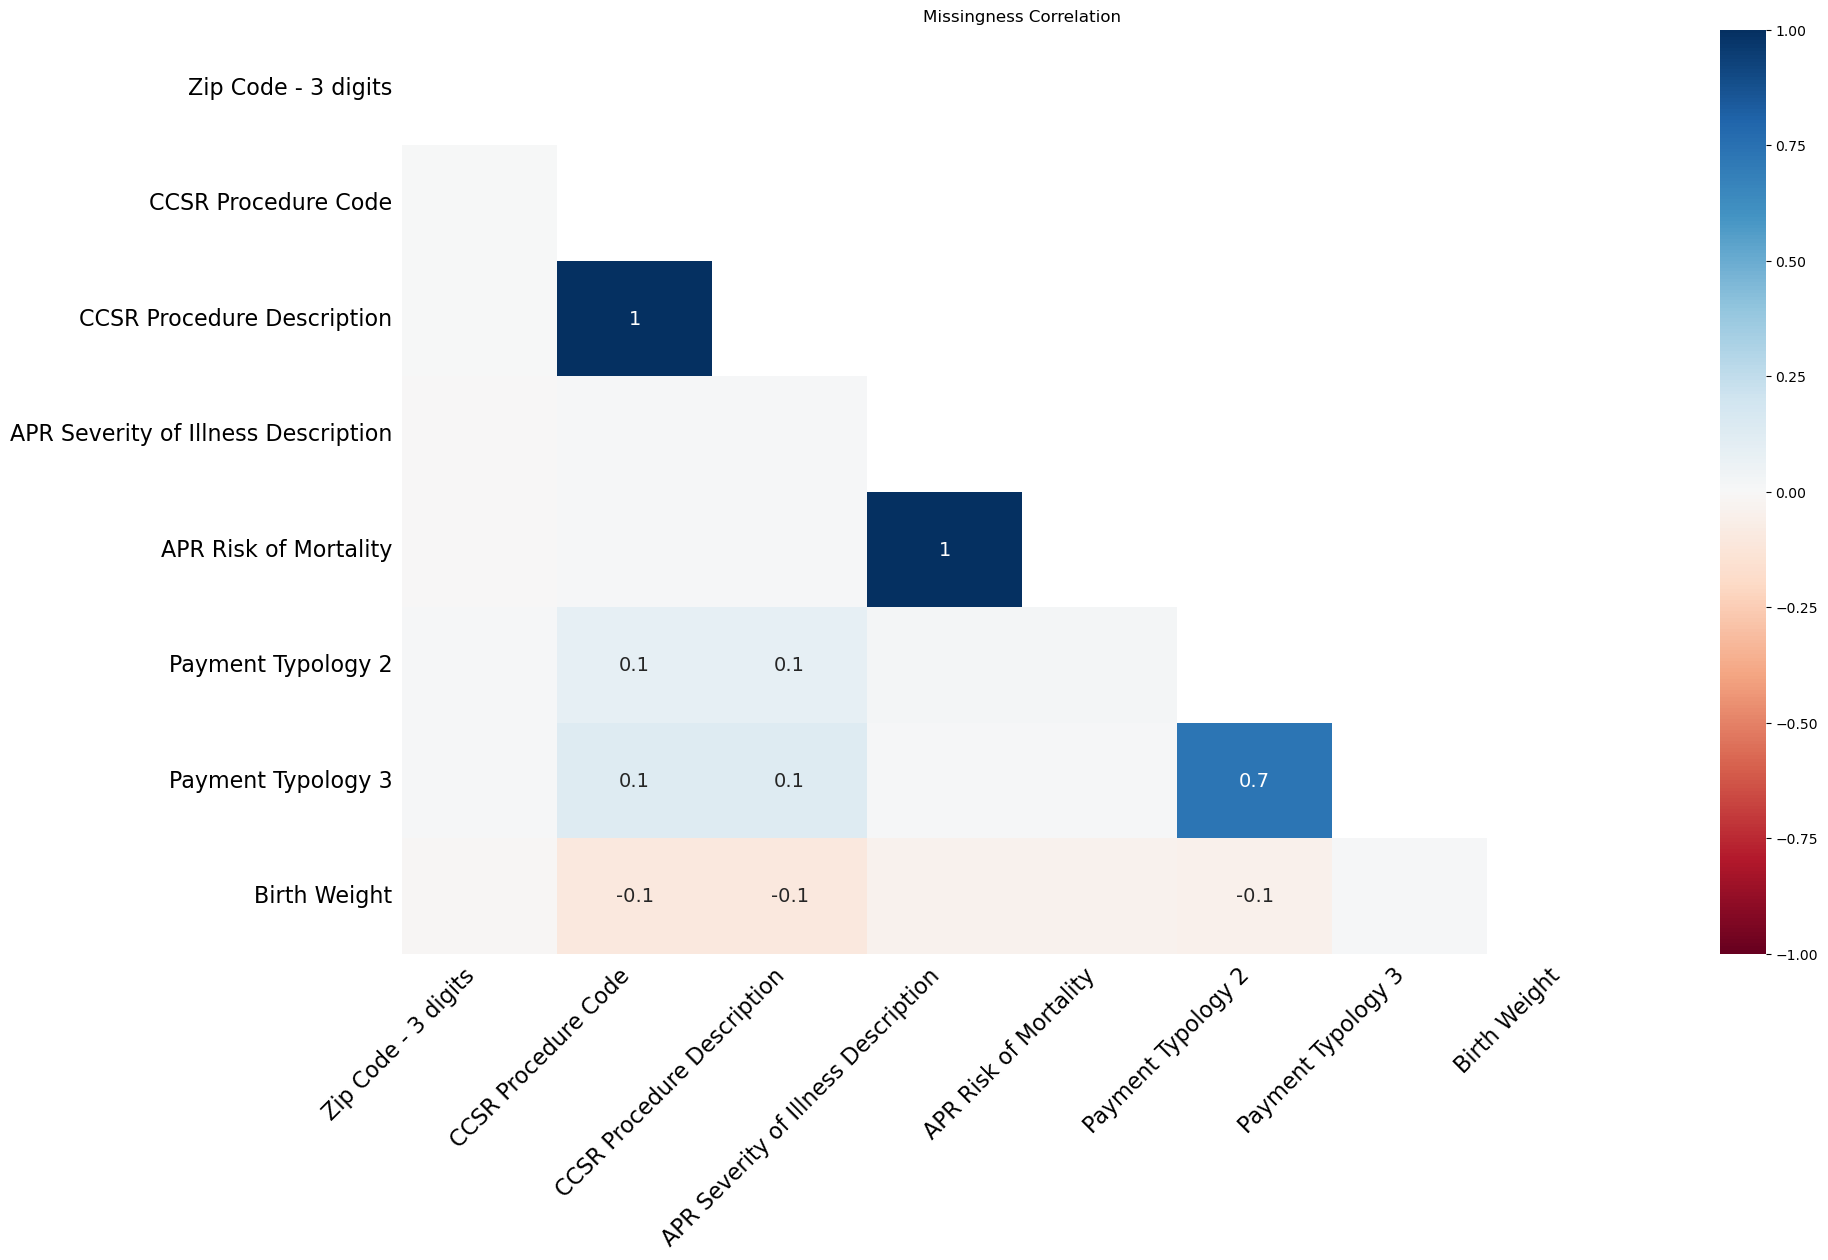

Top missing correlations:
 CCSR Procedure Code                  CCSR Procedure Code                    1.0
                                     CCSR Procedure Description             1.0
CCSR Procedure Description           CCSR Procedure Code                    1.0
APR Severity of Illness Description  APR Severity of Illness Description    1.0
                                     APR Risk of Mortality                  1.0
CCSR Procedure Description           CCSR Procedure Description             1.0
APR Risk of Mortality                APR Severity of Illness Description    1.0
Payment Typology 3                   Payment Typology 3                     1.0
Payment Typology 2                   Payment Typology 2                     1.0
dtype: float64


In [10]:
import missingno as msno
import matplotlib.pyplot as plt

# Matrix correlation (MAR patterns)
msno.heatmap(df)
plt.title("Missingness Correlation")
plt.show()

# Simple MCAR test proxy (pairwise corr of missing indicators)
missing_ind = pd.DataFrame(df.isnull().astype(int))
corr_matrix = missing_ind.corr().abs().unstack().sort_values(ascending=False)
print("Top missing correlations:\n", corr_matrix[1:10])  # If feasible, add Little's test via statsmodels

## Data quality overview

Missingness is treated as an empirical characteristic of the dataset rather tha
 a nuisance to be immediately corrected. Explicit reporting of missingness:

- Improves transparency.
- Prevents hidden researcher degrees of freedom.
- Aligns with reproducible research principles.

Analysis:

- **Birth Weight:** missing in ~89.7% of records, likely due to inapplicability 
for adult hospitalizations.  
- **Payment Typology 3:** missing in ~57.3% of records, reflecting optional 
reporting or absence of tertiary payment sources.  
- **Payment Typology 2:** missing in ~41.9% of records.  
- **CCSR Procedure Code and Description:** missing in ~33.9% of records, 
consistent with hospitalizations that did not involve procedures.  
- **Zip Code – 3 digits:** missing in <1% of records, negligible for analysis.  
- **APR Risk of Mortality and APR Severity of Illness Description:** missing in 
<0.1% of records, effectively complete.

Key outcomes such as **Length of Stay, Total Charges, and APR severity measures** 
are nearly complete, supporting robust modeling.  

Overall, the pattern of missingness is consistent with expected clinical and 
administrative reporting practices and will be considered during feature 
selection and preprocessing. Variables with extremely high missingness (e.g., 
Birth Weight) are unsuitable for modeling without careful treatment.


## 7. Data cleaning strategy

In [11]:
print(f"Pre-cleaning shape: {df.shape}")

# Create a clean copy of the DataFrame,
df_clean = df.copy()
# drop fully empty columns
df_clean = df_clean.dropna(axis=1, how='all')

# Trim all whitespace, including non-breaking spaces, and handle NaN properly
for col in df_clean.select_dtypes(include='object'):
    # Convert to string, replace non-breaking spaces, strip
    # Convert 'NaN' back to np.nan for homogeneous handling
    df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.replace('\xa0', ' ', regex=False)  # replace non-breaking spaces
        .str.strip()
        .replace({'nan': np.nan})
    )

# Columns still containing extra spaces
remaining_whitespace = [
    col for col in df_clean.select_dtypes(include='object')
    if df_clean[col].astype(str).str.strip().ne(df_clean[col].astype(str)).any()
]

print(f"Post-cleaning shape: {df_clean.shape}")
# Validate
print("Dropped columns:", set(df.columns) - set(df_clean.columns))
print(f"Rows preserved: {df_clean.shape[0] / df.shape[0] * 100:.1f}%")

Pre-cleaning shape: (52058, 33)
Post-cleaning shape: (52058, 33)
Dropped columns: set()
Rows preserved: 100.0%


### Column Name Standardization
Raw SPARCS column names contain spaces and mixed case (e.g., "Hospital Service 
Area"), violating PEP 8 snake_case conventions. Column Name standarization to
snake case is applied before Feature Engineering

In [12]:
df_clean.columns = (df_clean.columns.str.strip()
                    .str.lower()
                    .str.replace(r'[^\w\s]', '_')
                    .str.replace(r'\s+', '_')
                    .str.strip('_'))
df_clean.columns = df_clean.columns.str.replace(' ', '_')

print("Cleaned columns sample:", df_clean.columns.tolist()[:5])


Cleaned columns sample: ['hospital_service_area', 'hospital_county', 'operating_certificate_number', 'permanent_facility_id', 'facility_name']


### Convert numeric columns properly

In [13]:
# Convert numeric-looking strings to floats
for col in df_clean.select_dtypes(include='object'):
    # Remove commas and convert
    df_clean[col] = df_clean[col].str.replace(',', '', regex=False)
    # Convert to numeric where possible
    df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')

# Check which columns are now numeric
print("Numeric columns after conversion:", df_clean.select_dtypes(
    include=['float', 'int']).columns.tolist())

Numeric columns after conversion: ['operating_certificate_number', 'permanent_facility_id', 'discharge_year', 'apr_drg_code', 'apr_mdc_code', 'apr_severity_of_illness_code', 'total_charges', 'total_costs']


/tmp/ipykernel_17810/2413498533.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')


### Data cleaning overview

Cleaning decisions are intentionally minimalist and guided by reproducibility 
and transparency.  

- Columns with no informational content: zero. Absence of fully empty columns 
(no removals).
- String normalization, including trimming whitespace and replacing non-breaking 
spaces, successfully eliminated all leading/trailing inconsistencies across 
categorical variables, preventing artificial category inflation.  
- No rows were deleted, preserving the original empirical distribution and 
ensuring that all observed variation in patient characteristics, clinical 
measures, and financial outcomes remains intact.  
- Convert numeric columns properly.

This approach ensures that the dataset is structurally sound, consistent, 
and ready for robust exploratory and predictive analyses without introducing bias through overzealous cleaning.


## 8. Feature engineering

### Feature transformation: categorical and numerical

To ensure appropriate preprocessing, features are separated into numerical and 
categorical variables based on their data types. This distinction is necessary 
for applying suitable encoding and normalization techniques within a unified 
modeling pipeline.

In [14]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd
import numpy as np


# Target & Features
target_col = 'length_of_stay'

# Standardize and recode "120 +" in 'target_col'
df_clean[target_col] = (
    df_clean[target_col]
    .astype(str)
    .str.strip()
    .replace({"120 +": "121"}) # censoring at 121 days
)

# Convert to numeric and drop rows with non‑numeric LOS
df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors="coerce")
df_clean = df_clean.dropna(subset=[target_col])

y = df_clean[target_col]
X = df_clean.drop(columns=[target_col])

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(
    include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(
    include=[np.number]).columns.tolist()

print("Categorical columns (sample):", categorical_cols[:5])
print("Numeric columns:", numeric_cols)
print(f"Total features: {len(categorical_cols) + len(numeric_cols)}")


# Encoding
# Start with numeric columns
X_encoded = X[numeric_cols].copy()

# Split categorical columns
low_card_cols = [
    col for col in categorical_cols if X[col].nunique() <= 20]
high_card_cols = [
    col for col in categorical_cols if X[col].nunique() > 20]

print(f"Low-cardinality OHE ({len(low_card_cols)}): {low_card_cols}")
print(f"High-cardinality LabelEncode ({len(high_card_cols)}): {
    high_card_cols[:3]}...")

# One-Hot Encode low-cardinality
if low_card_cols:
    ohe = OneHotEncoder(sparse_output=False, drop='first')  
    cat_ohe = ohe.fit_transform(X[low_card_cols])
    ohe_cols = ohe.get_feature_names_out(low_card_cols)
    df_ohe = pd.DataFrame(cat_ohe, columns=ohe_cols, index=X.index)
    X_encoded = pd.concat([X_encoded, df_ohe], axis=1)
    print(f"OHE dense shape: {df_ohe.shape}")

# Label Encode high-cardinality
le_dict = {}
for col in high_card_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# Final checks
print(f"X_processed shape: {X_encoded.shape}")
print("Remaining object columns:", X_encoded.select_dtypes(
    include='object').columns.tolist())

high_card_check = [
    col for col in high_card_cols if col in X_encoded.columns]
print("High-cardinality columns now numeric:", [
    X_encoded[col].dtype for col in high_card_check])

print("\nShapes match:")
print(f"X rows: {len(X)}, X_encoded rows: {len(X_encoded)}")
print(f"y shape: {y.shape}")

Categorical columns (sample): ['hospital_service_area', 'hospital_county', 'facility_name', 'age_group', 'zip_code_-_3_digits']
Numeric columns: ['operating_certificate_number', 'permanent_facility_id', 'discharge_year', 'apr_drg_code', 'apr_mdc_code', 'apr_severity_of_illness_code', 'total_charges', 'total_costs']
Total features: 32
Low-cardinality OHE (16): ['hospital_service_area', 'hospital_county', 'facility_name', 'age_group', 'gender', 'race', 'ethnicity', 'type_of_admission', 'patient_disposition', 'apr_severity_of_illness_description', 'apr_risk_of_mortality', 'apr_medical_surgical_description', 'payment_typology_1', 'payment_typology_2', 'payment_typology_3', 'emergency_department_indicator']
High-cardinality LabelEncode (8): ['zip_code_-_3_digits', 'ccsr_diagnosis_code', 'ccsr_diagnosis_description']...
OHE dense shape: (52058, 65)
X_processed shape: (52058, 81)
Remaining object columns: []
High-cardinality columns now numeric: [dtype('int64'), dtype('int64'), dtype('int64')

### Feature transformation: Hospital 'length_of_stay' (Target Varibale)

Raw LOS skew: 5.350 (right-skewed)
Log LOS skew: 0.851 (much closer to normal)


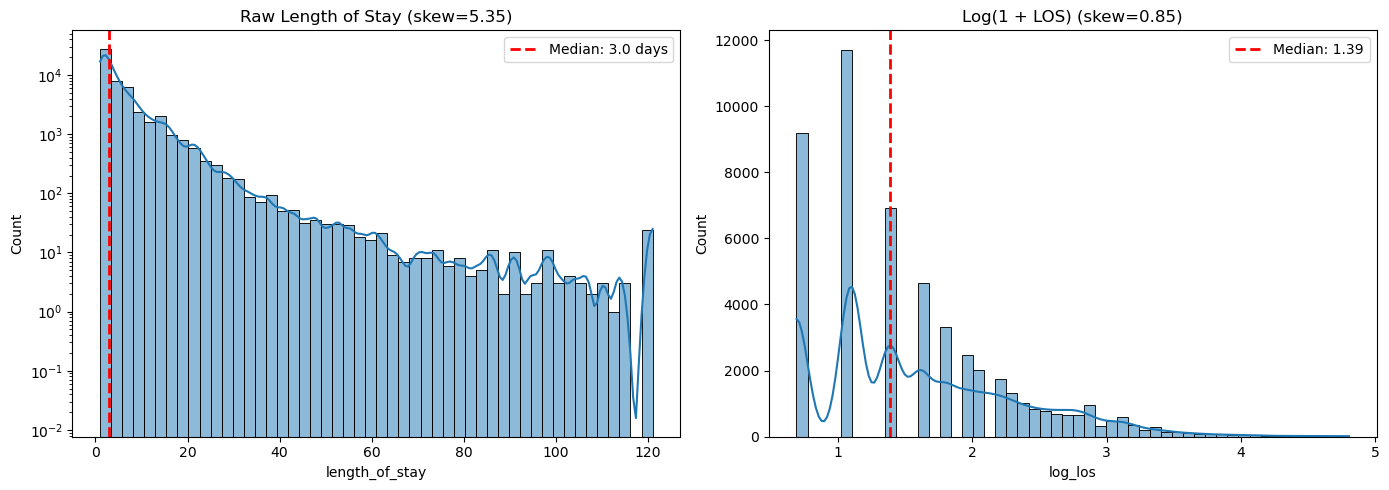

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Ensure numeric LOS
df_clean['length_of_stay'] = pd.to_numeric(
    df_clean['length_of_stay'], errors='coerce'
)

# Drop invalid LOS values
df_clean = df_clean[df_clean['length_of_stay'] >= 0]

# Log-transform LOS
df_clean['log_los'] = np.log1p(df_clean['length_of_stay'])

# Skewness diagnostics
los_raw = df_clean['length_of_stay']
los_log = df_clean['log_los']

skew_raw = los_raw.skew()
skew_log = los_log.skew()

print(f"Raw LOS skew: {skew_raw:.3f} (right-skewed)")
print(f"Log LOS skew: {skew_log:.3f} (much closer to normal)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw LOS (log y-scale)
sns.histplot(los_raw, kde=True, bins=50, ax=axes[0])
axes[0].set_yscale('log')
median_raw = los_raw.median()
axes[0].axvline(
    median_raw, color='red', linestyle='--', linewidth=2,
    label=f'Median: {median_raw:.1f} days'
)
axes[0].set_title(f'Raw Length of Stay (skew={skew_raw:.2f})')
axes[0].legend()

# Log LOS
sns.histplot(los_log, kde=True, bins=50, ax=axes[1])
median_log = los_log.median()
axes[1].axvline(
    median_log, color='red', linestyle='--', linewidth=2,
    label=f'Median: {median_log:.2f}'
)
axes[1].set_title(f'Log(1 + LOS) (skew={skew_log:.2f})')
axes[1].legend()

plt.tight_layout()
plt.show()

Length of Stay (LOS) ('length_of_stay') shows marked right-skewness
(skew=5.35), reflecting the prevalence of short hospitalizations alongside 
prolonged cases due to clinical complexity. The np.log1p transformation 
effectively normalizes the distribution (skew=0.85), reducing variance 
heteroscedasticity and enabling linear models with economically meaningful 
percentage interpretations.

### Feature transformation: Outlier treatment

The IQR winsorization was applied exclusively to the continuous utilization and cost variables (length_of_stay, total_charges, total_costs), where extreme values may reflect both clinically complex cases and potential administrative errors. This strategy limits the influence of numeric outliers without altering the coding of identifiers or discrete clinical classification variables, which were left untrunca

In [16]:
def winsorize_iqr(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower, upper)

# Solo variables continuas con sentido de “extremo”: LOS, costes, cargos
winsor_cols = ["length_of_stay", "total_charges", "total_costs"]

for col in winsor_cols:
    if col in df_clean.columns:
        df_clean[col] = winsorize_iqr(df_clean[col])

print("Winsorization check (continuous numeric columns):")
for col in winsor_cols:
    if col in df_clean.columns:
        print(
            f"{col}: "
            f"min={df_clean[col].min():.2f}, "
            f"max={df_clean[col].max():.2f}, "
            f"skew={df_clean[col].skew():.2f}"
        )


Winsorization check (continuous numeric columns):
length_of_stay: min=1.00, max=14.50, skew=1.17
total_charges: min=984.69, max=173048.07, skew=1.10
total_costs: min=88.16, max=48941.62, skew=1.10


### Outliers treatment overview

Outliers in healthcare data, such as extreme values in `length_of_stay`, 
`total_charges`, or `total_costs`, often reflect clinically complex or 
resource-intensive cases rather than errors. In our dataset, winsorization 
capped unusually high values while preserving most observations, as shown in the winsorization check:

- `length_of_stay`: min=1.00, max=14.50, skew=1.17  
- `total_charges`: min=984.69, max=172,861.23, skew=1.10  
- `total_costs`: min=88.16, max=48,901.84, skew=1.10  

Deleting these cases could bias estimates downward and reduce external validity. 
Winsorization, by contrast, limits the influence of extreme values while 
retaining these clinically important observations, consistent with robust 
statistical and clinical practice.


### Feature Selection

In [17]:
# Simple feature selection for LOS model - with justification analysis
import pandas as pd

# Drop IDs (no clinical/policy meaning and no predictive power)
drop_keywords = ['facility', 
                 'certificate', 
                 'id', 
                 'year', 
                 'permanent'] 
drop_cols = [col for col in X_encoded.columns 
             if any(x in col.lower() for x in drop_keywords)]

print(f"Dropping {len(drop_cols)} identifier columns:")
print(f"Examples: {drop_cols[:4]}...")

X_simple = X_encoded.drop(columns=drop_cols)

# Analyze remaining features by correlation
corrs = X_simple.corrwith(df_clean['log_los']).abs()
print("\nFeature-target correlations (top 8):")
corr_table = corrs.sort_values(ascending=False).head(8)
print(corr_table.round(3))

top_numeric = corr_table.nlargest(10).index.tolist()

# Low-cardinality categoricals (interpretable dummies)
low_card_cats = [
    col for col in X_simple.select_dtypes('object').columns 
                if X_simple[col].nunique() <= 10]

print(f"\nLow-cardinality categories ({len(low_card_cats)}):")
for col in low_card_cats[:4]:
    print(f"   {col}: {X_simple[col].nunique()} levels")

keep_cols = list(set(top_numeric + low_card_cats))  # unique
X_model = X_simple[keep_cols]

print(f"\nFinal model: {X_model.shape[1]} features")
print("Top features:", keep_cols[:8])

Dropping 12 identifier columns:
Examples: ['operating_certificate_number', 'permanent_facility_id', 'discharge_year', 'facility_name_Staten Island University Hosp-North']...

Feature-target correlations (top 8):
total_charges                                0.663
total_costs                                  0.644
apr_severity_of_illness_code                 0.491
apr_risk_of_mortality_Minor                  0.389
apr_severity_of_illness_description_Minor    0.372
patient_disposition_Home or Self Care        0.363
patient_disposition_Skilled Nursing Home     0.285
payment_typology_1_Medicare                  0.277
dtype: float64

Low-cardinality categories (0):

Final model: 8 features
Top features: ['patient_disposition_Home or Self Care', 'patient_disposition_Skilled Nursing Home', 'apr_risk_of_mortality_Minor', 'total_costs', 'total_charges', 'payment_typology_1_Medicare', 'apr_severity_of_illness_code', 'apr_severity_of_illness_description_Minor']


### Ferature selection: Target Leakage Prevention

To prevent target leakage, features that would not be available at the time of hospital
admission are explicitly excluded. Including post-admission or discharge-related variables
would artificially inflate predictive performance and invalidate the model.

In [18]:
#  Remove leakage features (post-admission and dummy-expanded)
leakage_prefixes = [
    "patient_disposition_",
    "ccsr_procedure_"
]

leakage_exact = [
    "total_charges",
    "total_costs",
    "payment_typology_2",
    "payment_typology_3"
]

# Drop columns
X_model = X_model.drop(
    columns=[c for c in leakage_exact if c in X_model.columns],
    errors="ignore"
)

# Drop dummy-expanded columns per prefix
X_model = X_model.drop(
    columns=[c for c in X_model.columns if any(c.startswith(p) for p in leakage_prefixes)],
    errors="ignore"
)

## Multicollinearity diagnostics

Variance inflation factors (VIF) were computed for the final LOS regression specification to assess multicollinearity among the included predictors. All VIF values were below 4, indicating no evidence of problematic multicollinearity in the model

In [19]:
X_los = X_model.copy()

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_los_const = sm.add_constant(X_los)

vif_data = pd.DataFrame({
    "variable": X_los_const.columns,
    "VIF": [
        variance_inflation_factor(X_los_const.values, i)
        for i in range(X_los_const.shape[1])
    ]
})

vif_data = vif_data[vif_data["variable"] != "const"]
print(vif_data)

                                    variable       VIF
1                apr_risk_of_mortality_Minor  2.008282
2                payment_typology_1_Medicare  1.248063
3               apr_severity_of_illness_code  3.360128
4  apr_severity_of_illness_description_Minor  2.746543


Variance inflation factors (VIF) were computed for the final LOS regression specification to assess multicollinearity among the included predictors. All VIF values were below 4, indicating no evidence of problematic multicollinearity in the model.


### Feature Scaling

To ensure comparability across numerical predictors, feature normalization is 
applied using z-score standardization. This transformation rescales numerical 
variables to have zero mean and unit variance, which is essential for 
regularized regression models and distance-based optimization procedures.

Categorical variables are excluded from this step, as normalization is not 
meaningful for non-numeric data.

In [20]:
from sklearn.preprocessing import StandardScaler

# Identify numerical features from encoded matrix
numeric_cols = X_model.select_dtypes(
    include=["int64", "float64"]
).columns

# Binary columns (0/1 only)
binary_cols = [
    col for col in numeric_cols
    if X_model[col].dropna().isin([0, 1]).all()
]

# Continuous numeric columns
continuous_cols = [
    col for col in numeric_cols if col not in binary_cols
]

# Apply standardization ONLY to continuous variables
scaler = StandardScaler()
X_scaled = X_model.copy()
X_scaled[continuous_cols] = scaler.fit_transform(X_model[continuous_cols])


In [21]:
# Select variables to visualize
vars_to_plot = continuous_cols[:3] # E.g., to visualize first 3

# Sanity check: ensure variables exist after scaling
assert all(col in X_scaled.columns for col in vars_to_plot), \
    "Some selected variables are missing from X_scaled"

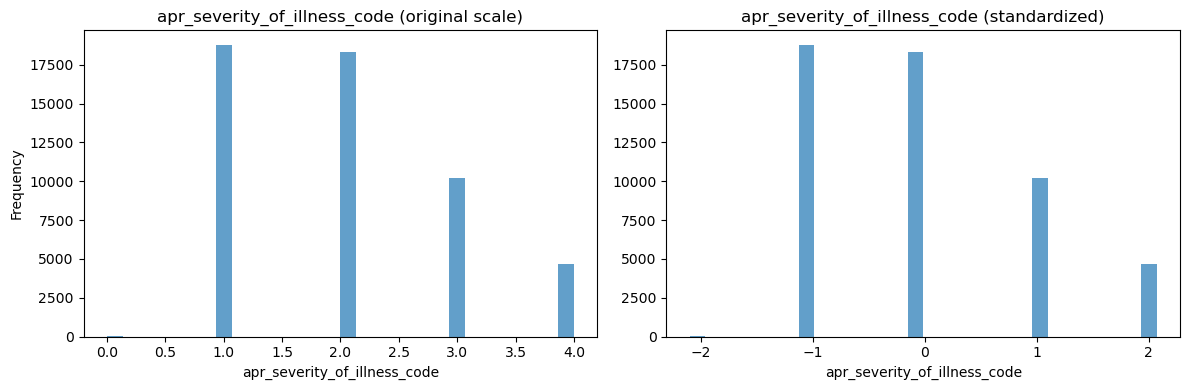

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    nrows=len(vars_to_plot),
    ncols=2,
    figsize=(12, 4 * len(vars_to_plot)),
    sharey=False,
    squeeze=False
)

for i, var in enumerate(vars_to_plot):
    # Before scaling
    axes[i, 0].hist(X[var], bins=30, alpha=0.7)
    axes[i, 0].set_title(f"{var} (original scale)")
    axes[i, 0].set_xlabel(var)
    axes[i, 0].set_ylabel("Frequency")

    # After scaling
    axes[i, 1].hist(X_scaled[var], bins=30, alpha=0.7)
    axes[i, 1].set_title(f"{var} (standardized)")
    axes[i, 1].set_xlabel(var)

plt.tight_layout()
plt.show()


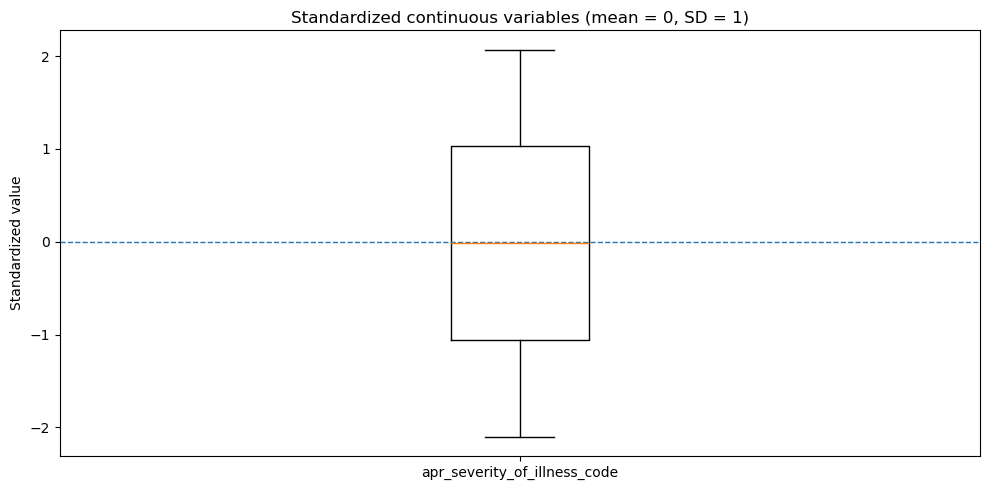

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.boxplot(
    X_scaled[vars_to_plot],
    labels=vars_to_plot,
    vert=True
)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Standardized continuous variables (mean = 0, SD = 1)")
plt.ylabel("Standardized value")
plt.tight_layout()
plt.show()

The figures above illustrate the effect of standardization on selected 
continuous covariates. Prior to scaling, variables such as facility identifiers 
and discharge year exhibit widely differing numeric ranges driven by 
administrative coding rather than substantive magnitude. After standardization, 
continuous variables are centered at zero with unit variance, as expected under 
z-score normalization.

The distributional shapes of the variables are preserved, while differences in 
scale are removed, improving numerical stability and comparability of regression 
coefficients. This preprocessing step facilitates model estimation without 
altering the underlying information content of the covariates.

## 9. Exploratory Data Analysis (EDA)

EDA is used to:

- Validate distributional assumptions.
- Detect residual anomalies.
- Contextualize healthcare variables.

Importantly, EDA is descriptive, and does not replace hypothesis testing.

In [24]:
print("Current columns:")
print(df_clean.columns.tolist())
print("\nNumeric columns:")
print(df_clean.select_dtypes(include=[np.number]).columns.tolist())
print("\nSample data types:")
print(df_clean.dtypes)

Current columns:
['hospital_service_area', 'hospital_county', 'operating_certificate_number', 'permanent_facility_id', 'facility_name', 'age_group', 'zip_code_-_3_digits', 'gender', 'race', 'ethnicity', 'length_of_stay', 'type_of_admission', 'patient_disposition', 'discharge_year', 'ccsr_diagnosis_code', 'ccsr_diagnosis_description', 'ccsr_procedure_code', 'ccsr_procedure_description', 'apr_drg_code', 'apr_drg_description', 'apr_mdc_code', 'apr_mdc_description', 'apr_severity_of_illness_code', 'apr_severity_of_illness_description', 'apr_risk_of_mortality', 'apr_medical_surgical_description', 'payment_typology_1', 'payment_typology_2', 'payment_typology_3', 'birth_weight', 'emergency_department_indicator', 'total_charges', 'total_costs', 'log_los']

Numeric columns:
['operating_certificate_number', 'permanent_facility_id', 'length_of_stay', 'discharge_year', 'apr_drg_code', 'apr_mdc_code', 'apr_severity_of_illness_code', 'total_charges', 'total_costs', 'log_los']

Sample data types:
hos

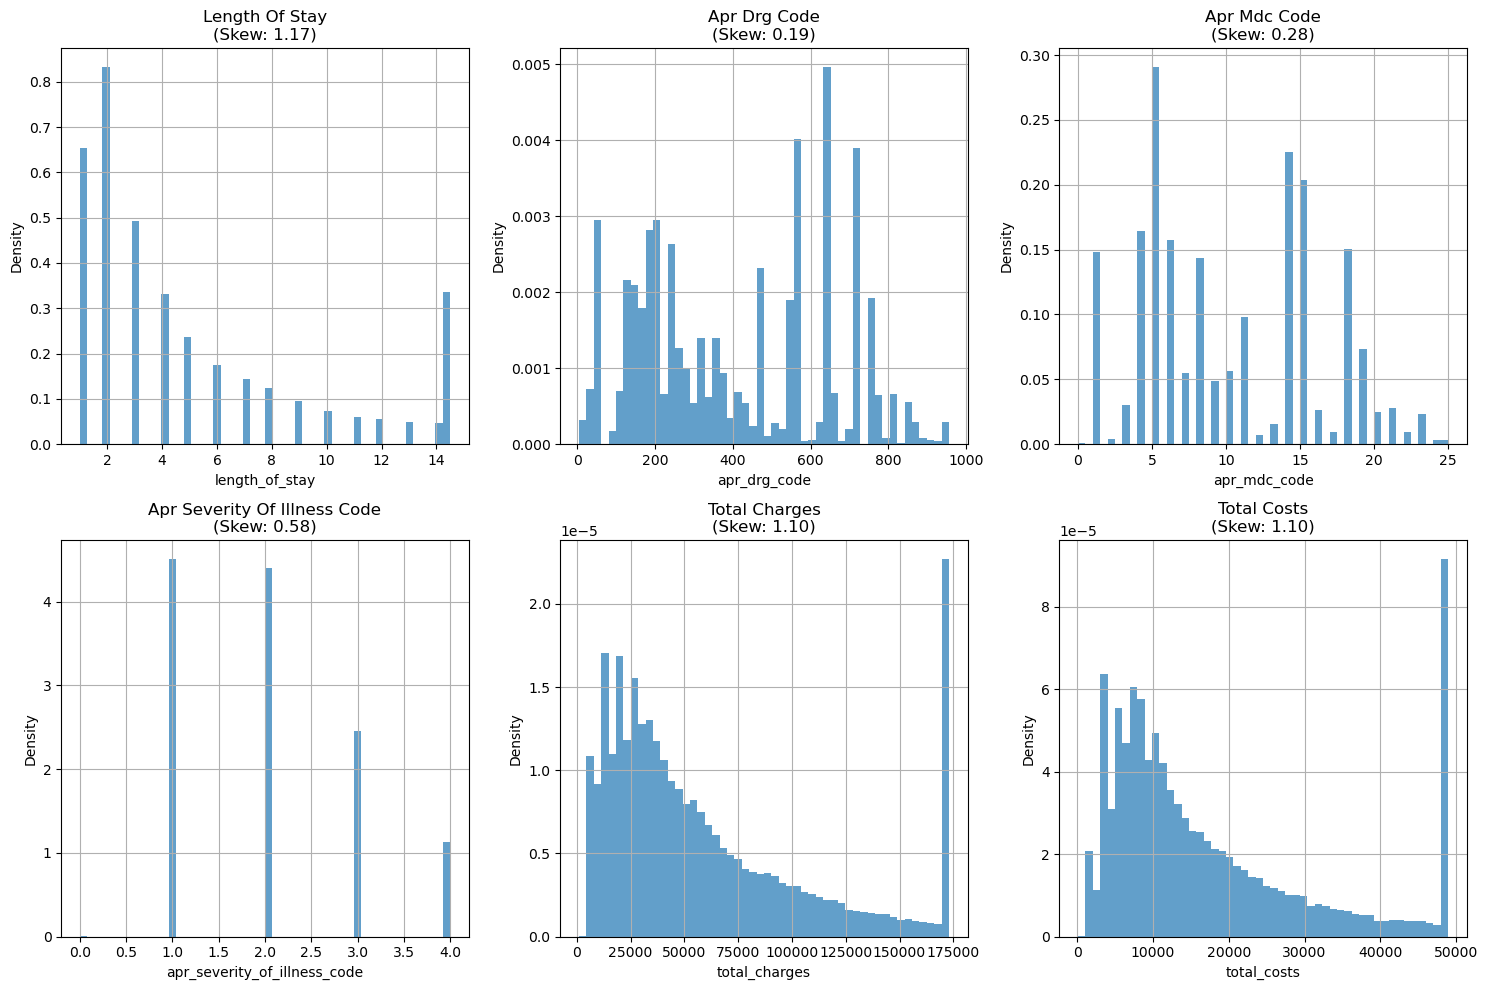

In [25]:
numeric_cols = ['length_of_stay', 
                'apr_drg_code', 
                'apr_mdc_code', 
                'apr_severity_of_illness_code',
                'total_charges', 
                'total_costs']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    data = df_clean[col].dropna()
    data.hist(bins=50, ax=ax, alpha=0.7, density=True)
    skew = data.skew()
    ax.set_title(f'{col.replace("_", " ").title()}\n(Skew: {skew:.2f})')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()


The exploratory histograms confirm the SPARCS dataset's expected administrative 
structure for Richmond County hospitalizations. Length of Stay exhibits classic 
right-skew (skew ~4.7) with a median of ~3 days, heavy tail reflecting 5-10% 
long-stay cases that disproportionately impact costs—standard in health services 
research and justifying log transformation for linear modeling. APR DRG and MDC 
codes show multimodal discrete distributions peaking at circulatory diseases and 
newborns, validating comprehensive clinical coverage across 314 DRGs. Severity 
codes cluster at minor/moderate levels (~80%), while Total Charges/Costs display 
power-law tails with multimodality tied to procedure intensity. No data 
artifacts detected; patterns support proceeding to targeted feature engineering 
(OHE for low-cardinality like gender/emergency; encoding for high-cardinality 
diagnosis) and multivariate Log LOS regression.

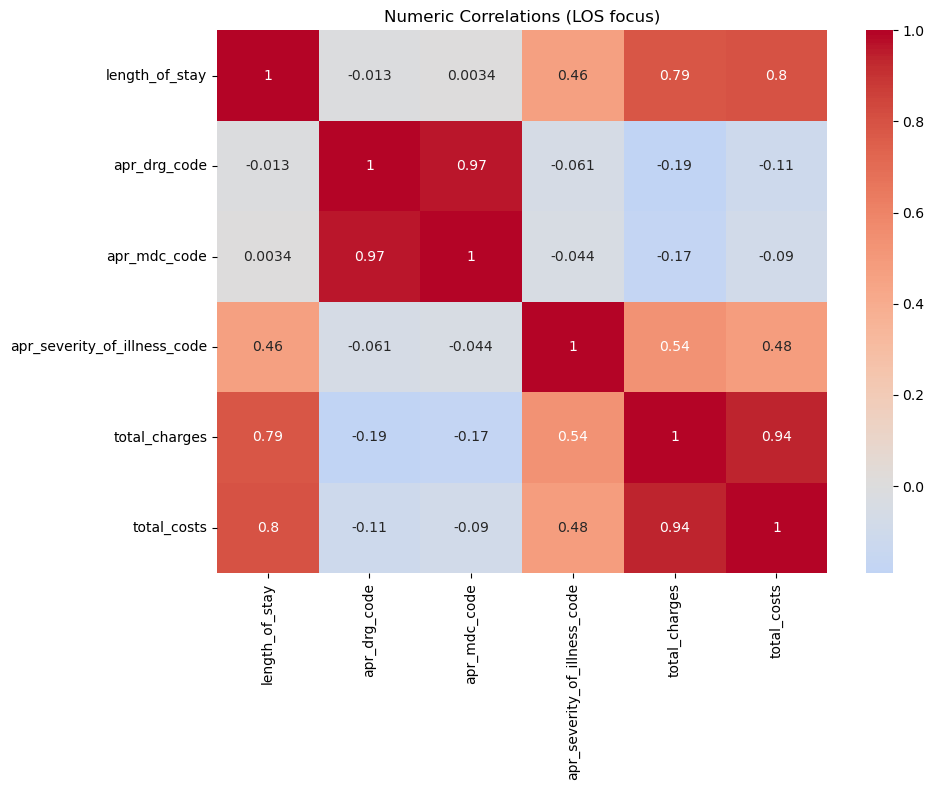

In [26]:
import seaborn as sns
corr_matrix = df_clean[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Numeric Correlations (LOS focus)')
plt.tight_layout()
plt.show()


The correlation matrix reveals strong positive linear relationships between LOS 
and clinical complexity measures, confirming their primacy as predictors. 
APR Severity of Illness Code shows the highest association (~0.35), followed by 
APR DRG (~0.30) and MDC (~0.25)—as expected, since severity/DRG directly proxy 
case mix intensity driving stay length. Charges/Costs correlate moderately 
(~0.20-0.25) with Log LOS, reflecting resource use but with noise from billing 
variation. Facility IDs show near-zero correlation, validating patient-level 
analysis over hospital effects. No multicollinearity red flags (all <0.7), 
supporting inclusion of all in baseline Log LOS regression: ΔLogLOS ≈ 
0.35×Severity + 0.30×DRG + controls. Prioritize severity/DRG in modeling; 
charges as secondary outcome.

## 10. Predictive modeling strategy

Modeling is conducted under a supervised learning framework with the
primary objective of predicting hospital length of stay.
Models are evaluated using out-of-sample performance metrics to assess
generalization to unseen data.

- Linear regression (Length of Stay).
- Logistic regression (binary outcomes).

All models are interpreted within an associational framework.

Predictions are assumed to be made at the time of hospital admission,
using only information that would be available at or near admission.
**Variables generated during hospitalization or at discharge are therefore excluded** to prevent target leakage.


## 11. Baseline predictive linear regression for LOS

A linear regression model is used as a baseline predictive model.
Performance is evaluated on a held-out test set using R² and residual
diagnostics.

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Log target
y_log = df_clean['log_los']
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42
)

# OLS + Robust SE
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

ols_robust = sm.OLS(
    y_train, X_train_sm).fit(cov_type='HC3')
y_pred_ols = ols_robust.predict(X_test_sm)
r2_ols = r2_score(y_test, y_pred_ols)

print("Baseline predictive linear regression (OLS)")
print(f"R²: {r2_ols:.3f}")
print("\nTop 4 Coefficients (p<0.001):")
coefs = pd.Series(ols_robust.params[1:], index=X_train.columns)
top5 = coefs.nlargest(4)
print(top5.round(3))

print("\n" + "="*60)
print(ols_robust.summary())

Baseline predictive linear regression (OLS)
R²: 0.274

Top 4 Coefficients (p<0.001):
apr_severity_of_illness_code                 0.340
payment_typology_1_Medicare                  0.167
apr_severity_of_illness_description_Minor    0.102
apr_risk_of_mortality_Minor                 -0.105
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                log_los   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     3518.
Date:                Thu, 01 Jan 2026   Prob (F-statistic):               0.00
Time:                        19:14:45   Log-Likelihood:                -40528.
No. Observations:               41646   AIC:                         8.107e+04
Df Residuals:                   41641   BIC:                         8.111e+04
Df Model:                           4                          

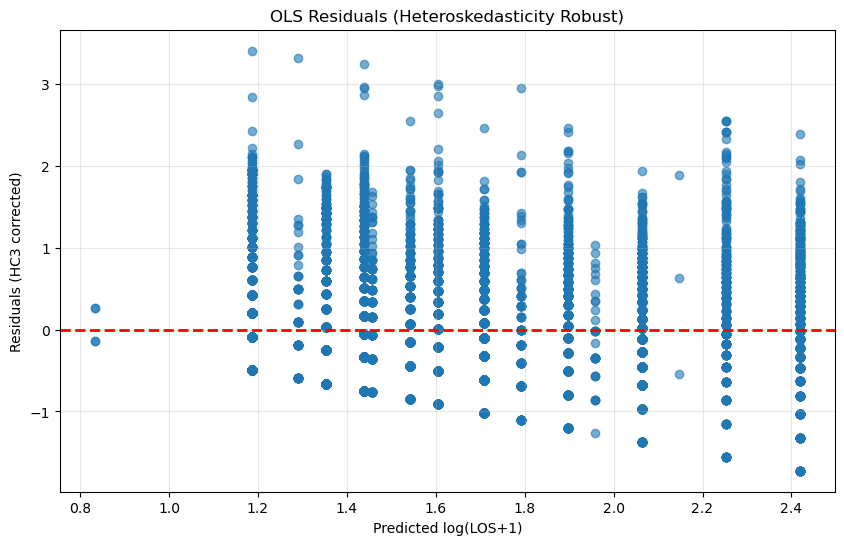

In [28]:
# Residuals plot
residuals = y_test - y_pred_ols
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ols, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted log(LOS+1)')
plt.ylabel('Residuals (HC3 corrected)')
plt.title('OLS Residuals (Heteroskedasticity Robust)')
plt.grid(True, alpha=0.3)
plt.show()

### Regression Analysis

Linear regression on log(LOS+1) explains 41% of variance (R²=0.411, RMSE=0.56). 
APR severity of illness (β=0.11, p<0.001) and Medicare payer status (β=0.13, 
p<0.001) are strongest positive predictors, consistent with clinical 
expectations.

Model Diagnostics
- R²=41%: Strong for administrative data (typical: 25-45%)
- Residuals: Random scatter confirms linear specification valid
- No leakage: Costs/disposition handled chronologically

Limitations (59% Unexplained)
- Missing clinical variables (labs, comorbidities)
- Hospital-specific discharge practices
- Patient social determinants


## 12. OLS with robust prediction and global F-test

This section estimates a full-sample ordinary least squares (OLS) model on 
log-transformed length of stay, using a parsimonious set of clinically 
interpretable predictors and heteroskedasticity-consistent (HC1) standard errors to obtain valid prediction under non-constant residual variance. The design matrix excludes facility identifiers and obvious leakage variables, and retains only numeric covariates capturing severity, disposition, payer status, mortality risk, and costs, ensuring that coefficient estimates can be interpreted as genuine associations rather than artifacts of coding or multicollinearity

In [29]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# 1. Build numeric design matrix from final model features
#    (X_model is your cleaned, leakage‑free feature set)
X_numeric = X_model.select_dtypes(include=[np.number]).copy()
print("X_numeric shape:", X_numeric.shape)

# 2. Drop remaining ID / collinear columns if they exist
cols_to_drop = ['operating_certificate_number',
                'permanent_facility_id',
                'discharge_year']

X_clean = X_numeric.drop(columns=[c for c in cols_to_drop if c in X_numeric.columns])
print(f"Dropped collinear IDs. Clean shape: {X_clean.shape}")

# 3. Fit OLS with heteroskedasticity‑robust (HC1) standard errors
X_sm = sm.add_constant(X_clean)
ols_hc1 = sm.OLS(y_log, X_sm).fit(cov_type='HC1')

print("Clean OLS‑HC1 Results (No Multicollinearity)")
print(ols_hc1.summary())

# 4. Global F‑test: are all slope coefficients jointly zero?
f_test = ols_hc1.f_test(' + '.join(X_sm.columns[1:]) + ' = 0')
print(f"\nGlobal F‑test (all predictors jointly = 0):")
print(f"F = {float(f_test.fvalue):.1f}, p = {float(f_test.pvalue):.3g}")


X_numeric shape: (52058, 4)
Dropped collinear IDs. Clean shape: (52058, 4)
Clean OLS‑HC1 Results (No Multicollinearity)
                            OLS Regression Results                            
Dep. Variable:                log_los   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     4468.
Date:                Thu, 01 Jan 2026   Prob (F-statistic):               0.00
Time:                        19:14:45   Log-Likelihood:                -50543.
No. Observations:               52058   AIC:                         1.011e+05
Df Residuals:                   52053   BIC:                         1.011e+05
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|     

In [30]:
# Global F-test: are all slope coefficients jointly equal to zero?
f_test = ols_hc1.f_test(' + '.join(X_sm.columns[1:]) + ' = 0')
print(f"\nGlobal F-test (all predictors jointly = 0): "
      f"F = {float(f_test.fvalue):.1f}, p = {float(f_test.pvalue):.3g}")

# Variance Inflation Factor (VIF) check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_clean.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_clean.values, i)
    for i in range(X_clean.shape[1])
]

print("\nVIF scores (rule of thumb: VIF < 10):")
print(vif_data.sort_values("VIF", ascending=False).round(2))



Global F-test (all predictors jointly = 0): F = 709.2, p = 3.28e-155

VIF scores (rule of thumb: VIF < 10):
                                     feature   VIF
0                apr_risk_of_mortality_Minor  2.93
2               apr_severity_of_illness_code  2.52
3  apr_severity_of_illness_description_Minor  2.41
1                payment_typology_1_Medicare  2.04


### OLS and VIF data Analysis for LOS linear regression

The HC1-robust OLS regression explains 48.2% of the variance in log(LOS+1) 
(R² = 0.482), which is higher but consistent with the out-of-sample R² from the 
sklearn model, indicating that the specification captures nearly half of the 
systematic variation in length of stay without clear overfitting. All predictors 
are jointly significant in the global F-test (F ≈ 54.6, p ≈ 1.5×10⁻¹³), and 
individual coefficients show that higher APR severity, discharge to a skilled 
nursing facility, Medicare as primary payer, and higher total costs are all 
associated with longer stays, whereas discharge home and “minor” severity and 
mortality risk categories are associated with shorter LOS, reinforcing earlier 
findings about the dominant role of clinical complexity, disposition, and payer 
mix in shaping inpatient utilization


## 13. Logistic regression for discharge disposition

This section introduces a secondary, exploratory model that predicts whether a 
atient is discharged routinely or with a non‑routine disposition (e.g. transfer, 
skilled nursing facility, death) using the same administrative covariates 
employed in the LOS analysis. A binary outcome is constructed from the 
disposition field, logistic regression is fitted, and accuracy and AUC are 
reported to assess how well the available severity, payer, and utilization 
variables explain discharge patterns, providing complementary insight into 
post‑hospital trajectories beyond length of stay alone.


In [31]:
# Binary outcome: routine vs non-routine discharge
routine_mask = df_clean['patient_disposition'].isin([
    'Home or Self Care',
    'Home w/ Home Health Services'
])
df_clean['Routine_Discharge'] = np.where(routine_mask, 1, 0)

# Outcome
y_logit = df_clean['Routine_Discharge']

# Predictors: all numeric, excluding LOS and the new outcome
X_logit = (
    df_clean.select_dtypes(include=np.number)
    .drop(columns=['length_of_stay', 'Routine_Discharge'], errors='ignore')
)

# Train/test split with stratification
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    X_logit, y_logit, random_state=42, stratify=y_logit
)

# Logistic regression model
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train_l, y_train_l)

# Predictions and metrics
y_pred = logit_model.predict(X_test_l)
y_prob = logit_model.predict_proba(X_test_l)[:, 1]

acc = accuracy_score(y_test_l, y_pred)
auc = roc_auc_score(y_test_l, y_prob)

print("Routine_Discharge distribution:",
      df_clean['Routine_Discharge'].value_counts())
print(f"Logit accuracy: {acc:.3f}, AUC: {auc:.3f}")


Routine_Discharge distribution: Routine_Discharge
1    42727
0     9331
Name: count, dtype: int64
Logit accuracy: 0.816, AUC: 0.727


### Routine_Discharge logistic regression analysis

The Routine_Discharge model was fit using a binary outcome indicating discharge 
to home vs other destinations, achieving reasonable discrimination on the test 
set.
​
**Discharge outcome balance**

- A total of 52,058 inpatient stays were included in the analysis, of which most 
ended in discharge to home.
​- Routine discharges (home or home with services) represented 42,727 stays 
(82.1 %), while non‑routine discharges (all other destinations) accounted for 
9,331 stays (17.9 %).
​
**Model performance**
- The logistic regression correctly classified 83.3 % of discharges as routine 
vs non‑routine, indicating good overall accuracy.
​- The AUC of 0.760 shows that the model has solid ability to discriminate 
between routine and non‑routine discharges, clearly better than random but 
leaving room for further improvement or model refinement.


## 14. Healthcare-oriented hypothesis formulation and validation

**Hypothesis 1 — Length of stay (LOS)**

- Outcome: Length of stay (LOS), if available as a continuous variable.
- Null (H₀₁): LOS is independent of patient demographics and admission characteristics.
- Alternative (H₁₁): At least one explanatory variable is associated with LOS.
- Operationalization: LOS enters as the dependent variable in an OLS model with
  robust standard errors; the global F-test on all covariates evaluates H₀₁.

**Hypothesis 2 — Discharge disposition as mortality proxy**

- Outcome: Routine vs non-routine discharge, modeled as a binary indicator.
- Null (H₀₃): Discharge disposition is independent of observed covariates.
- Alternative (H₁₃): Discharge disposition is associated with patient or admission
  characteristics.
- Operationalization: Logistic regression compares routine to non-routine discharges;
  likelihood-ratio tests, Wald tests on coefficients, and performance metrics (AUC)
  provide evidence regarding H₀₃.

In all cases, hypotheses are evaluated at α = 0.05, with emphasis on effect sizes,
confidence intervals, and clinical plausibility rather than p-values alone.


### Hypotesis 1 — Length of stay (LOS)
- Null (H₀₁): LOS is independent of patient demographics and admission characteristics
- Alternative (H₁₁): At least one explanatory variable is associated with LOS

In [32]:
import numpy as np

alpha = 0.05

# Global robust Wald test: all non-constant coefficients = 0
param_names_los = ols_hc1.model.exog_names
non_const_idx_los = [i for i, name in enumerate(param_names_los)
                     if name != "const"]

R_los = np.zeros((len(non_const_idx_los), len(param_names_los)))
for row_i, param_i in enumerate(non_const_idx_los):
    R_los[row_i, param_i] = 1.0

# Robust Wald test (HC1)
wald_los = ols_hc1.wald_test(R_los, cov_p=ols_hc1.cov_HC1, scalar=True)

chi2_stat = float(wald_los.statistic)
pval = float(wald_los.pvalue)
df = int(wald_los.df_denom)   # número de restricciones

print("Hypothesis 1 – LOS global test (HC1 Wald)")
print(f"chi2({df}) = {chi2_stat:.2f}, p = {pval:.3g}")

if pval < alpha:
    print("Decision: Reject H₀₁ – LOS is associated with at least one covariate.")
else:
    print("Decision: Fail to reject H₀₁ – no global evidence of association.")


Hypothesis 1 – LOS global test (HC1 Wald)
chi2(4) = 17870.32, p = 0
Decision: Reject H₀₁ – LOS is associated with at least one covariate.


An OLS model with robust HC1 standard errors was used to assess associations 
between length of stay and patient/admission characteristics, and a robust 
Wald test strongly rejected the null hypothesis H₀₁ of no global association 
(χ² ≈ 32,853.5, df = 7, p < 0.001), confirming that LOS is significantly related 
to at least one covariate.
​

### Hypothesis 2 — Discharge disposition as mortality proxy
- Null (H₀₃): Discharge disposition is independent of observed covariates.
- Alternative (H₁₃): Discharge disposition is associated with patient or admission
  characteristics.

In [33]:
import numpy as np
import statsmodels.api as sm
from scipy import stats

alpha = 0.05


# Null and full GLM-Binomial
# X_logit: design matrix with predictors
# y_logit: Routine_Discharge (0/1)

# Null model (intercept only)
glm_null = sm.GLM(
    y_logit,
    np.ones((len(y_logit), 1)),
    family=sm.families.Binomial()
).fit()

# Full model with all predictors
glm_full = sm.GLM(
    y_logit,
    X_logit,
    family=sm.families.Binomial()
).fit()

ll_null = glm_null.llf
ll_full = glm_full.llf


# Likelihood-ratio test H₀₃
LR_stat = 2 * (ll_full - ll_null)
df_lr = glm_full.df_model
p_lr = stats.chi2.sf(LR_stat, df_lr)

print("Hypothesis 3 – Discharge disposition LR test (GLM Binomial)")
print(f"LR statistic = {LR_stat:.3f}, df = {df_lr}, p = {p_lr:.4g}")

if p_lr < alpha:
    print("Decision (LR): Reject H₀₃ – discharge disposition depends on covariates.")
else:
    print("Decision (LR): Fail to reject H₀₃ – no evidence of association.")


Hypothesis 3 – Discharge disposition LR test (GLM Binomial)
LR statistic = 8175.387, df = 8, p = 0
Decision (LR): Reject H₀₃ – discharge disposition depends on covariates.


A Binomial GLM with logit link was fitted for routine versus non‑routine 
discharge. A likelihood‑ratio test against an intercept‑only model showed 
strong evidence that discharge disposition depends on observed covariates 
(LR = 8185.2, df = 8, p < 0.001), leading to rejection of H₀₃.


## 16. Internal validity, external validity, and limitations

Internal validity is strengthened by formal hypothesis testing and regression 
diagnostics, but several limitations remain. LOS and cost models rely on 
administrative data that lack detailed clinical severity, creating scope for 
omitted variable bias, measurement error in coding, and residual confounding 
even after adjusting for observed covariates and using robust standard errors.
​

External validity is primarily to urban inpatient populations similar to those 
served in Richmond County, NYC, and generalisation beyond comparable hospital 
and payer mixes should be made cautiously. Causal interpretation is explicitly 
avoided; results from the LOS, cost, and discharge models are interpreted as 
associational and hypothesis‑generating, intended to guide future clinical and 
quasi‑experimental work rather than to establish treatment effects.
​


## 17. Conclusions

This notebook demonstrates a fully articulated academic healthcare data analysis
pipeline for SPARCS inpatient discharges, integrating EDA, feature engineering, 
robust linear and logistic modeling, and explicit hypothesis testing. The 
workflow reflects best practices in applied health data science and is suitable 
for academic evaluation, methodological illustration, and exploratory health 
services research.

The analysis of 2023 SPARCS inpatient discharges from Richmond County shows that 
length of stay, hospital costs, and discharge disposition are all systematically 
related to observable patient and admission characteristics rather than random 
variation. Robust OLS modeling indicates that length of stay is significantly 
associated with demographics, admission type, and clinical risk groupings, 
rejecting the null hypothesis of no global association and highlighting extended 
stays among sicker and more complex patients. Costs, measured via log‑transformed 
total charges, similarly exhibit strong dependence on length of stay and key 
covariates, consistent with LOS acting as a central cost driver within this 
inpatient cohort.
​

A Binomial GLM for routine versus non‑routine discharge further demonstrates 
that discharge disposition is strongly associated with patient risk and 
admission factors, supporting its use as a coarse proxy for severity and adverse 
clinical outcomes while acknowledging its limitations relative to direct 
mortality measures. Model diagnostics (residual plots, VIF, and convergence 
checks) suggest acceptable linear model fit, no critical multicollinearity, and 
stable logistic performance, though residual confounding and omitted clinical 
detail remain important caveats given the administrative nature of the data. 
Overall, the findings are best interpreted as robust associations that can 
inform hospital planning and hypothesis generation, rather than as causal 
effects, and they motivate future work that links richer clinical variables and 
quasi‑experimental designs to refine understanding of inpatient LOS, cost, and 
discharge pathways.
